In [ ]:
## Connect Google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
main_path = "/content/gdrive/MyDrive/Thesis/kaggle"
train_path = f"{main_path}/image_classification/data/train"
test_path = f"{main_path}/image_classification/data/test"


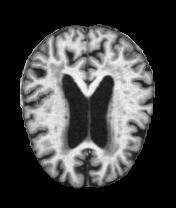

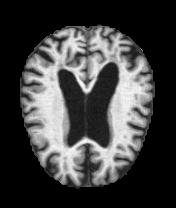

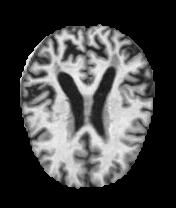

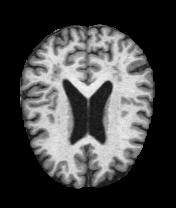

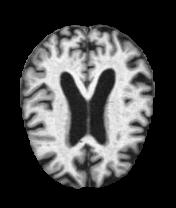

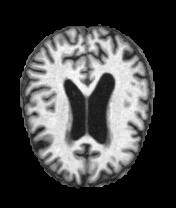

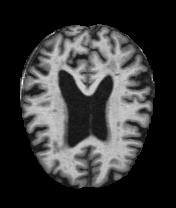

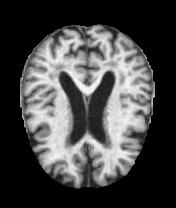

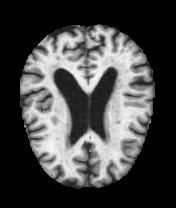

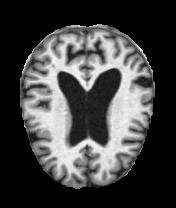

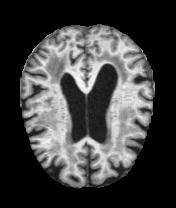

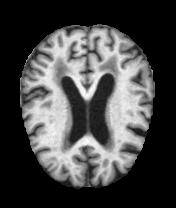

Total:  1299


In [ ]:
import glob
from IPython.display import Image, display

i = 0
limit = 12 # max images to print
for gr in ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]:
  for imageName in glob.glob(f'{test_path}/{gr}/*.jpg'): #assuming JPG
      #print(imageName)
      if i < limit:
        display(Image(filename=imageName))
        #print("\n")
        pass
      i = i + 1
print("Total: ", i)

In [ ]:
!pip install typeguard

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tqdm
import glob

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet, mobilenet, efficientnet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

In [ ]:
!nvidia-smi

Sun Jul 16 11:35:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )


In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = f'{train_path}',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)


Found 4099 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = f'{train_path}',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = f'{test_path}',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1299 images belonging to 4 classes.


### Train ResNet Model

In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

# Define the ResNet model
resnet_model = resnet.ResNet50(weights='imagenet')
# Load the ResNet50 model
#resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model for your classification task
model = Sequential()
model.add(resnet_model)
model.add(Dense(4, activation='softmax'))  # Assuming you have 10 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the ResNet model
"""
model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)"""
model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    verbose = 1
)

102967424/102967424 [==============================] - 1s 0us/step
Epoch 1/5
129/129 [==============================] - 1137s 8s/step - loss: 1.2776 - accuracy: 0.5040 - val_loss: 1.2227 - val_accuracy: 0.5019
Epoch 2/5
129/129 [==============================] - 79s 612ms/step - loss: 1.1857 - accuracy: 0.4996 - val_loss: 1.1529 - val_accuracy: 0.5019
Epoch 3/5
129/129 [==============================] - 78s 602ms/step - loss: 1.1355 - accuracy: 0.4996 - val_loss: 1.1150 - val_accuracy: 0.5019
Epoch 4/5
129/129 [==============================] - 79s 611ms/step - loss: 1.1064 - accuracy: 0.4996 - val_loss: 1.0918 - val_accuracy: 0.5019
Epoch 5/5
129/129 [==============================] - 78s 606ms/step - loss: 1.0883 - accuracy: 0.4996 - val_loss: 1.0767 - val_accuracy: 0.5019


### Evaluate ResNet Model


In [ ]:
# Evaluate the ResNet model
resnet_scores = model.evaluate(test_dataset, steps=len(test_dataset))
resnet_scores

41/41 [==============================] - 5s 110ms/step - loss: 1.0767 - accuracy: 0.5019


[1.076697826385498, 0.5019245743751526]

### Train MobileNet Model


In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

# Define the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

# Create a new model for your classification task
model = Sequential()
model.add(mobilenet_model)
model.add(Dense(4, activation='softmax'))  # Assuming you have 10 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the ResNet model
model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    verbose = 1
)

Epoch 1/5
129/129 [==============================] - 96s 577ms/step - loss: 1.2772 - accuracy: 0.5167 - val_loss: 1.2373 - val_accuracy: 0.5027
Epoch 2/5
129/129 [==============================] - 68s 528ms/step - loss: 1.1758 - accuracy: 0.4996 - val_loss: 1.1432 - val_accuracy: 0.5019
Epoch 3/5
129/129 [==============================] - 67s 521ms/step - loss: 1.1271 - accuracy: 0.4996 - val_loss: 1.1070 - val_accuracy: 0.5019
Epoch 4/5
129/129 [==============================] - 66s 509ms/step - loss: 1.0998 - accuracy: 0.4996 - val_loss: 1.0858 - val_accuracy: 0.5019
Epoch 5/5
129/129 [==============================] - 67s 515ms/step - loss: 1.0830 - accuracy: 0.4996 - val_loss: 1.0721 - val_accuracy: 0.5019


### Evaluate MobileNet Model

In [ ]:
# Evaluate the MobileNet model
mobilenet_scores = model.evaluate(test_dataset, steps=len(test_dataset))

41/41 [==============================] - 4s 91ms/step - loss: 1.0721 - accuracy: 0.5019


### Train EfficientNet Model

In [ ]:
import tensorflow.keras.backend as K
K.clear_session()

# Define the EfficientNet model
efficientnet_model = efficientnet.EfficientNetB0(weights='imagenet')

# Create a new model for your classification task
model = Sequential()
model.add(efficientnet_model)
model.add(Dense(4, activation='softmax'))  # Assuming you have 10 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the ResNet model
model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
    verbose = 1
)

21834768/21834768 [==============================] - 0s 0us/step
Epoch 1/5
129/129 [==============================] - 124s 585ms/step - loss: 1.2792 - accuracy: 0.5218 - val_loss: 1.3057 - val_accuracy: 0.5019
Epoch 2/5
129/129 [==============================] - 72s 560ms/step - loss: 1.1786 - accuracy: 0.5062 - val_loss: 1.1943 - val_accuracy: 0.5019
Epoch 3/5
129/129 [==============================] - 73s 566ms/step - loss: 1.1090 - accuracy: 0.4977 - val_loss: 1.1183 - val_accuracy: 0.5019
Epoch 4/5
129/129 [==============================] - 74s 573ms/step - loss: 1.0807 - accuracy: 0.5001 - val_loss: 1.1117 - val_accuracy: 0.5019
Epoch 5/5
129/129 [==============================] - 72s 558ms/step - loss: 1.0459 - accuracy: 0.5082 - val_loss: 1.1001 - val_accuracy: 0.5019


### Evaluate EfficientNet Model

In [ ]:
# Evaluate the EfficientNet model
efficientnet_scores = model.evaluate(test_dataset, steps=len(test_dataset))
efficientnet_scores

41/41 [==============================] - 7s 169ms/step - loss: 1.1001 - accuracy: 0.5019


[1.1000832319259644, 0.5019245743751526]

### Train Decision Tree Model

In [ ]:
# Define the Decision Tree model
decision_tree_model = DecisionTreeClassifier()

In [ ]:
# Preprocess the training data as flat vectors
train_images = []
train_labels = []
for images, labels in train_dataset:
    train_images.extend(images)
    train_labels.extend(np.argmax(labels, axis=1))
    if len(train_images) >= len(train_dataset):
        break
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Preprocess the test data as flat vectors
test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.extend(images)
    test_labels.extend(np.argmax(labels, axis=1))
    if len(test_images) >= len(test_dataset):
        break
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [ ]:
# Reshape the images for the Decision Tree model
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [ ]:
# Train the Decision Tree model
decision_tree_model.fit(train_images, train_labels)

DecisionTreeClassifier()

In [ ]:
# Evaluate the Decision Tree model
decision_tree_scores = decision_tree_model.score(test_images, test_labels)
decision_tree_scores

0.515625

### Train Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(train_images, train_labels)

RandomForestClassifier()

### Evaluate Random Forest

In [ ]:
rf_scores = rf_model.score(test_images, test_labels)
rf_scores

0.484375

### Train Adaboost Model

In [ ]:
# Define the AdaBoost model with Decision Tree as base estimator
adaboost_model = AdaBoostClassifier(base_estimator=decision_tree_model)

# Train the AdaBoost model
adaboost_model.fit(train_images, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

### Evaluate AdaBoost

In [ ]:
# Evaluate the AdaBoost model
adaboost_scores = adaboost_model.score(test_images, test_labels)
adaboost_scores

0.5

### Train XGBoost Model

In [ ]:
# Convert the training and test data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(train_images, label=train_labels)
dtest = xgb.DMatrix(test_images, label=test_labels)

# Set the parameters for XGBoost model
xgb_params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': len(np.unique(train_labels)),
}


In [ ]:
# Train the XGBoost model
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [ ]:
# Evaluate the XGBoost model
xgb_preds = xgb_model.predict(dtest)
xgb_scores = np.sum(xgb_preds == test_labels) / len(test_labels)
xgb_scores

0.421875

### Performance Comparison

In [ ]:
print("ResNet scores:", round(resnet_scores[-1]*100, 2))
print("MobileNet scores:", round(mobilenet_scores[-1]*100, 2))
print("EfficientNet scores:", round(efficientnet_scores[-1]*100, 2))
print("Decision Tree score:", round(decision_tree_scores*100, 2))
print("AdaBoost score:", round(adaboost_scores*100, 2))
print("XGBoost score:", round(xgb_scores*100, 2))
print("Random Forest score:", round(rf_scores*100, 2))

ResNet scores: 50.19
MobileNet scores: 50.19
EfficientNet scores: 50.19
Decision Tree score: 51.56
AdaBoost score: 50.0
XGBoost score: 42.19
Random Forest score: 48.44


In [ ]:
model_names = ["ResNet50", "MobileNet", "EfficientNet", "Decision Tree", "Adaboost", "Xgboost", "Random Forest"]
model_vals = [round(resnet_scores[-1]*100, 2), round(mobilenet_scores[-1]*100, 2), round(efficientnet_scores[-1]*100, 2),
                  round(decision_tree_scores*100, 2), round(adaboost_scores*100, 2), round(xgb_scores*100, 2), round(rf_scores*100, 2)]

In [ ]:
model_scores_df = pd.DataFrame(list(zip(model_names, model_vals)), columns=["model", "scores"])
model_scores_df

,model,scores
0,ResNet50,50.19
1,MobileNet,50.19
2,EfficientNet,50.19
3,Decision Tree,51.56
4,Adaboost,50.00
5,Xgboost,42.19
6,Random Forest,48.44


In [ ]:
model_scores_df.to_csv(f"{main_path}/image_classification/kaggle_image_classification_models_scores.csv", index=False)

### Hyperoptimize decision tree classifier

In [ ]:
dt_model = DecisionTreeClassifier()
#result = dt_model.fit(train_images, train_labels)


In [ ]:
#Hyperparameter optimization
grid_space={'max_depth':[2,4,6,8,10,12],
              "criterion": ['gini', 'entropy'],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }
"""
grid_space={"n_components": list(range(1,train_images.shape[1]+1,1)),
              "criterion": ['gini', 'entropy'],
              "max_depth": [2,4,6,8,10,12]
            }  #[3,5,10,None]   'n_estimators':[10,100,200],"""

'\ngrid_space={"n_components": list(range(1,train_images.shape[1]+1,1)),\n              "criterion": [\'gini\', \'entropy\'],\n              "max_depth": [2,4,6,8,10,12]  \n            }  #[3,5,10,None]   \'n_estimators\':[10,100,200],'

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(dt_model, param_grid=grid_space, cv=3, scoring='accuracy')
model_grid = grid.fit(train_images, train_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
432 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr

In [ ]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 3}
Best score is: 0.5811786629396692


In [ ]:
# mobilenet.MobileNet
"""
base_model = ResNet50(input_shape=(224,224,3),
                   include_top=False,

                   weights="imagenet")  """
"""#efficient net
base_model = efficientnet.EfficientNetB0(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")
"""
base_model = mobilenet.MobileNet(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))




In [ ]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_6 (Batc  (None, 50176)            200704    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 64)                3211328   
                                                                 
 batch_normalization_7 (Batc  (None, 64)              

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 60,
                        verbose = 1,
                        callbacks=lr_scheduler)

Epoch 1/60
129/129 [==============================] - 70s 472ms/step - loss: 1.0760 - accuracy: 0.7557 - precision: 0.5230 - recall: 0.2584 - auc: 0.7761 - f1_score: 0.3395 - val_loss: 1.9911 - val_accuracy: 0.7554 - val_precision: 0.5125 - val_recall: 0.4409 - val_auc: 0.7871 - val_f1_score: 0.4741 - lr: 0.0100
Epoch 2/60
129/129 [==============================] - 61s 471ms/step - loss: 0.9722 - accuracy: 0.7874 - precision: 0.6616 - recall: 0.3062 - auc: 0.8185 - f1_score: 0.4177 - val_loss: 1.3730 - val_accuracy: 0.7776 - val_precision: 0.5799 - val_recall: 0.4008 - val_auc: 0.7994 - val_f1_score: 0.4733 - lr: 0.0089
Epoch 3/60
129/129 [==============================] - 61s 471ms/step - loss: 0.9303 - accuracy: 0.7942 - precision: 0.6921 - recall: 0.3181 - auc: 0.8306 - f1_score: 0.4336 - val_loss: 1.1813 - val_accuracy: 0.7881 - val_precision: 0.6219 - val_recall: 0.3891 - val_auc: 0.8069 - val_f1_score: 0.4770 - lr: 0.0079
Epoch 4/60
129/129 [==============================] - 60s 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(f"{main_path}/image_classification/mobilenet_81_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights(f"{main_path}/image_classification/mobilenet_81_model.h5")
print("Saved model to disk")

Saved model to disk


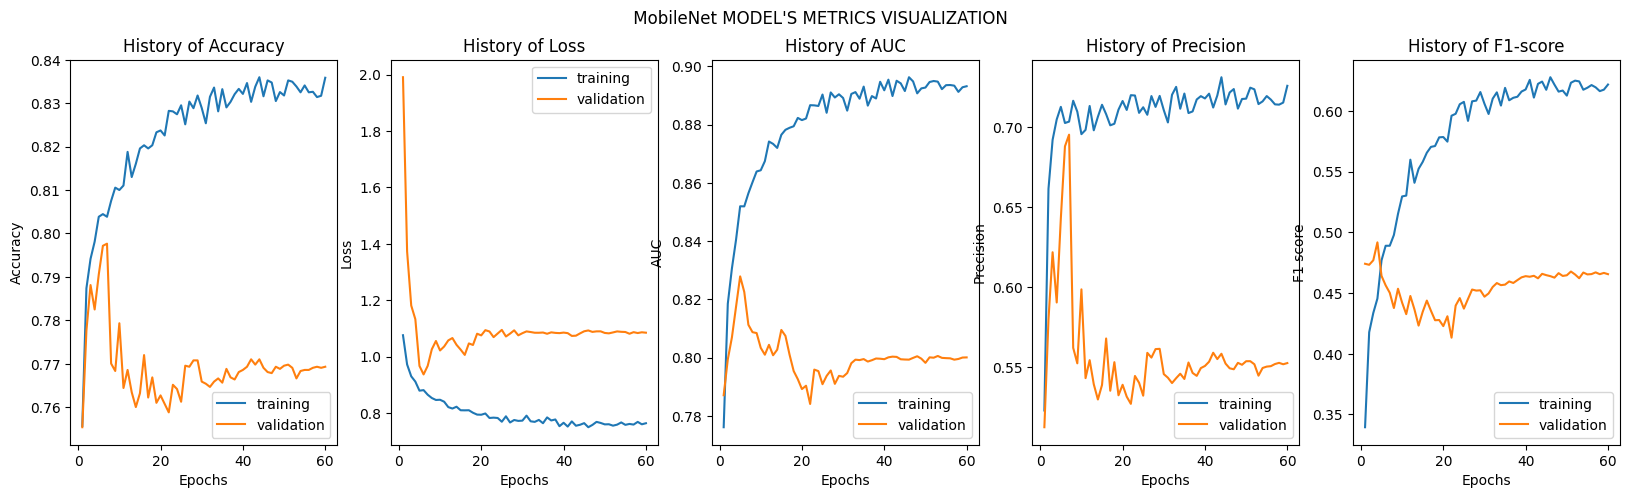

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MobileNet MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])

    plt.savefig(f"{main_path}/image_classification/kaggle_MobileNet_metric.jpg")
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )


In [ ]:
scores = model.evaluate_generator(test_dataset)

print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

<ipython-input-37-44d5d2294d80>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataset)


Accuracy =  0.8144726753234863
Precision =  0.6578699350357056
Recall =  0.5373364090919495
AUC =  0.8658429980278015
F1_score =  0.5939501523971558


In [ ]:
#f"{main_path}/pretrain_resnet_model.json"
from tensorflow.keras.models import Sequential, model_from_json

# load json and create model
json_file = open(f"{main_path}//image_classification/mobilenet_83_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(f"{main_path}//image_classification/mobilenet_83_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
loaded_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
scores = loaded_model.evaluate_generator(test_dataset)

print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

<ipython-input-56-9bca5286d258>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = loaded_model.evaluate_generator(test_dataset)


Accuracy =  0.8206312656402588
Precision =  0.6700648665428162
Recall =  0.556581974029541
AUC =  0.8620489239692688
F1_score =  0.6079510450363159


In [ ]:
print(loaded_model)

In [ ]:
from PIL import Image
from keras.preprocessing import image

image = f"{test_path}/VeryMildDemented/26 (44).jpg"
#image = Image.open(image)
image = tf.keras.utils.load_img(image)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32') / 255.  # This is VERY important
input_arr = input_arr.reshape(1, 224, 224, 3)

ValueError: ignored

In [ ]:
image = f"{test_path}/NonDemented/26 (64).jpg"  #26 (27).jpg     VeryMildDemented/26 (44).jpg  MildDemented/26 (27).jpg
# image = Image.open(image)
image = tf.keras.utils.load_img(image, target_size=(224, 224))  # Resize the image to (224, 224)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)  # Add an extra dimension for batch
input_arr = input_arr.astype('float32') / 255.  # Normalize the image


In [ ]:
img_path = f"{test_path}/MildDemented/26 (27).jpg"  # Replace with the path to your image file
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
input_arr = preprocess_input(x)

In [ ]:
res_img = loaded_model.predict(input_arr)


1/1 [==============================] - 0s 23ms/step


In [ ]:
res_img

array([[0.15073825, 0.00552539, 0.44569024, 0.39804605]], dtype=float32)

In [ ]:

# Get the index of the maximum probability value
predicted_class_index = np.argmax(res_img)

# Define the class labels corresponding to the indices
#class_labels = ['Class1', 'Class2', 'Class3', 'Class4']
class_labels = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the result
print("The predicted class is:", predicted_class_label)


The predicted class is: NonDemented
